In [1]:
# --- Standard Library Imports ---
import sys
import os
import time
import shutil
from pathlib import Path
from typing import Dict, Any, Callable, List, Set

# Set TensorFlow log level before import
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- Core Data Science & Visualization Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Interactive Widget Imports ---
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Scikit-learn Imports ---
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# --- Deep Learning & Optimization Library Imports ---
# These are in a try-except block as they are critical for modeling
# and might not be installed in all environments.
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (
        Input, Dense, LSTM, GRU, SimpleRNN,
        Conv1D, MaxPooling1D, Flatten, Dropout
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.metrics import BinaryAccuracy, SparseCategoricalAccuracy
    import keras_tuner as kt
    from bayes_opt import BayesianOptimization
    KERAS_AVAILABLE = True
except ImportError as e:
    print(f"⚠️ A critical modeling library might be missing: {e}. Modeling cells will fail.")
    KERAS_AVAILABLE = False

# --- Custom Module Imports ---
# Assumes 'src' directory is in the same folder as the notebook
sys.path.insert(0, str(Path.cwd() / 'src'))
try:
    from file_handler import setup_paths, load_multiple_datasets
    from data_exporter import export_data_interactive
    CUSTOM_MODULES_AVAILABLE = True
except ImportError:
    print("⚠️ Custom modules ('file_handler', 'data_exporter') not found in 'src' directory.")
    CUSTOM_MODULES_AVAILABLE = False

if KERAS_AVAILABLE and CUSTOM_MODULES_AVAILABLE:
    print("✅ All modules imported successfully!")

✅ All modules imported successfully!


### 1. Project Path and Data Loading

This step sets up the necessary paths and loads the dataset(s) for the analysis.

1.  **Path Setup (`setup_paths`)**: An interactive prompt will ask you to select the input folder (e.g., `02_data/raw`) and the output folder for saving results. This ensures the notebook can find your data and knows where to store models and plots.
2.  **Data Loading (`load_multiple_datasets`)**: The selected input folder is scanned for compatible files (CSV, Excel, Pickle). You can then choose one or more files to load. The function automatically handles different file formats and returns the data as a dictionary of pandas DataFrames.

Run this cell and follow the prompts to load your data.

In [2]:
# This cell now depends on the flag set in the import cell for cleaner logic.
if CUSTOM_MODULES_AVAILABLE:
    try:
        # Set up project paths and load data interactively.
        project_root, input_path, output_path = setup_paths()
        df_dict = load_multiple_datasets(input_path)

        # Handle the loaded data.
        if isinstance(df_dict, dict) and df_dict:
            if len(df_dict) == 1:
                # If only one dataset is loaded, extract it for convenience.
                df = next(iter(df_dict.values()))
                print("\n✅ Single dataset loaded and assigned to 'df'.")
            else:
                # Otherwise, keep the dictionary of DataFrames.
                df = df_dict
                print(f"\n✅ {len(df_dict)} datasets loaded into a dictionary named 'df'.")
        else:
            df = {}  # Ensure df exists even if loading fails
            print("\n⚠️ No datasets were loaded.")

    except Exception as e:
        print(f"⚠️ An error occurred during setup or data loading: {e}")
        # Define dummy variables to prevent errors in subsequent cells
        project_root = Path.cwd().parent
        input_path = Path.cwd() / "data" # Example dummy path
        output_path = Path.cwd() / "output" # Example dummy path
        df = {}
else:
    print("❌ Cannot run data loading because custom modules are missing.")
    # Define dummy variables to allow the notebook to be inspected without crashing.
    project_root, input_path, output_path, df = Path.cwd().parent, Path.cwd(), Path.cwd(), {}

📍 Current directory: C:\Users\User\Dropbox\Personal\CareerFoundry\07 Machine Learning\ML_unsupervised\03_notebooks
📁 Project root: C:\Users\User\Dropbox\Personal\CareerFoundry\07 Machine Learning\ML_unsupervised

📥 SELECT INPUT FOLDER

📋 Available folders in project:
   1: 01_roject_management
   2: 02_data
   3: 03_notebooks
   4: 04_analysis
   5: 05_results



>>> Choose input folder number (1-5):  2



✅ Selected: 02_data

----------------------------------------
📂 Subfolders in '02_data':
   0: Use '02_data' (parent folder)
   1: Merged_data
   2: Original_data
   3: Processed_data



>>> Choose subfolder (0-3) [Enter for 0]:  2



✅ Input path set to: C:\Users\User\Dropbox\Personal\CareerFoundry\07 Machine Learning\ML_unsupervised\02_data\Original_data


📤 SELECT OUTPUT FOLDER

📋 Available folders in project:
   1: 01_roject_management
   2: 02_data
   3: 03_notebooks
   4: 04_analysis
   5: 05_results

   💡 Press Enter to use input folder: 02_data\Original_data



>>> Choose output folder number (1-5) [Enter for input folder]:  2



✅ Selected: 02_data

----------------------------------------
📂 Subfolders in '02_data':
   0: Use '02_data' (parent folder)
   1: Merged_data
   2: Original_data
   3: Processed_data



>>> Choose subfolder (0-3) [Enter for 0]:  3




✅ PROJECT SETUP COMPLETE!

   📥 Input path:  C:\Users\User\Dropbox\Personal\CareerFoundry\07 Machine Learning\ML_unsupervised\02_data\Original_data
   📤 Output path: C:\Users\User\Dropbox\Personal\CareerFoundry\07 Machine Learning\ML_unsupervised\02_data\Processed_data


📋 Available data files:
   1: 📊 Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv (CSV)
   2: 📊 Dataset-weather-prediction-dataset-processed.csv (CSV)

🔍 How would you like to select files?
   1: Select specific files
   2: Load all files
   3: Load files by type (CSV, Excel, etc.)
   4: Load files matching a pattern



>>> Choose selection mode (1-4):  2



✅ Selected all 2 files

🔄 Loading 2 files...

[1/2] Loading: Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv
   ✅ Loaded: 22950 rows × 16 columns

[2/2] Loading: Dataset-weather-prediction-dataset-processed.csv
   ✅ Loaded: 22950 rows × 170 columns

📊 LOADING SUMMARY
✅ Successfully loaded: 2 files

📋 Loaded datasets:
   - Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv: 22950 rows × 16 columns
   - Dataset-weather-prediction-dataset-processed.csv: 22950 rows × 170 columns

✅ 2 datasets loaded into a dictionary named 'df'.


---
### 1a. Optional: Filter Data by Decade

Before proceeding with cleaning and modeling, you can choose to filter the dataset to a specific decade. This is useful for faster experimentation or for analyzing how weather patterns have changed over time. The default is to use the entire dataset.

In [3]:
# --- Optional: Interactive Date Filtering ---

# Back up the original dataframes
original_df_dict = df.copy() 
# df will now hold the potentially filtered data
global_decade_choice = {}

print("Original DataFrames loaded and backed up.")

try:
    # --- Robust Date Range Discovery ---
    # Find the overall min and max year across ALL files with a 'DATE' column.
    min_year, max_year = float('inf'), float('-inf')
    date_col_found = False

    for data in original_df_dict.values():
        if 'DATE' in data.columns:
            date_col_found = True
            # --- FIX: Explicitly provide the date format ---
            years = pd.to_datetime(data['DATE'], format='%Y%m%d', errors='coerce').dt.year
            
            # Update overall min and max, ignoring NaNs
            current_min = years.min()
            current_max = years.max()
            if pd.notna(current_min):
                min_year = min(min_year, current_min)
            if pd.notna(current_max):
                max_year = max(max_year, current_max)

    if not date_col_found:
        raise ValueError("No 'DATE' column found in any of the loaded datasets. Cannot create date filter.")

    min_year, max_year = int(min_year), int(max_year)

    # --- Create UI Widgets ---
    decades = [f"{year}-{year+9}" for year in range(min_year, max_year - 8, 10)]
    date_options = [('Full Dataset', 'all')] + [(decade, decade) for decade in decades]
    
    style = {'description_width': 'initial'}
    date_dropdown = widgets.Dropdown(
        options=date_options,
        value='all',
        description='Select a Time Range:',
        style=style
    )
    
    confirm_button = widgets.Button(description="Apply Filter", button_style='info')
    output_area = widgets.Output()

    def on_confirm_click(b):
        global df # We need to modify the global 'df' dictionary
        with output_area:
            output_area.clear_output()
            choice = date_dropdown.value
            global_decade_choice['selection'] = choice
            
            if choice == 'all':
                df = original_df_dict.copy() # Restore from backup
                print("✅ Using the full dataset.")
            else:
                start_year, end_year = map(int, choice.split('-'))
                print(f"✅ Filtering all datasets to the range: {start_year}-{end_year}")
                
                filtered_dfs = {}
                for name, data in original_df_dict.items():
                    if 'DATE' in data.columns:
                        temp_data = data.copy()
                        # --- FIX: Apply the same format here for filtering ---
                        temp_data['DATE'] = pd.to_datetime(temp_data['DATE'], format='%Y%m%d', errors='coerce')
                        mask = temp_data['DATE'].dt.year.between(start_year, end_year)
                        filtered_dfs[name] = temp_data.loc[mask].reset_index(drop=True)
                        print(f"   - '{name}' filtered. Original shape: {data.shape}, New shape: {filtered_dfs[name].shape}")
                    else:
                        print(f"   - '{name}' has no DATE column, skipping filter.")
                        filtered_dfs[name] = data.copy()
                df = filtered_dfs
            print("\nFiltering complete. You may now proceed.")

    confirm_button.on_click(on_confirm_click)
    display(widgets.VBox([date_dropdown, confirm_button, output_area]))

except Exception as e:
    print(f"An error occurred during date filtering setup: {e}")
    global_decade_choice['selection'] = 'all'

Original DataFrames loaded and backed up.


---
### 1b. Hypothesis Testing: Climate Trend Analysis

**Hypothesis 1 (from brief):** *Analyzing European temperature data from the last century reveals a statistically significant increasing trend in both annual mean and maximum temperatures, providing quantitative evidence of regional climate change.*

To validate this hypothesis, we will perform the following steps:
1.  **Isolate the Feature Data:** Select the dataset containing the daily weather observations.
2.  **Aggregate Daily Temperatures:** For each day, calculate the average "mean temperature" and "maximum temperature" across all available weather stations. This gives us a single representative value for the European region per day.
3.  **Calculate Annual Averages:** Group the daily aggregate data by year and compute the annual average for both mean and max temperatures.
4.  **Perform Linear Regression:** Analyze the relationship between the year and the annual average temperatures using linear regression.

The statistical significance of the trend will be determined by the **p-value** from the regression analysis. A p-value less than 0.05 indicates a statistically significant trend.

--- Yearly Average Temperatures (Sample) ---
   year  avg_mean_temp  avg_max_temp
0  1960       9.262508     12.721038
1  1961       9.759391     13.601370
2  1962       8.229619     11.837421
3  1963       8.244338     11.861144
4  1964       8.978036     12.582240

Analysis for 'Annual Mean Temperature Trend':
  - Slope: 0.0359 °C per year
  - P-value: 1.895022224442418e-14

Analysis for 'Annual Maximum Temperature Trend':
  - Slope: 0.0407 °C per year
  - P-value: 1.0748985720453431e-13


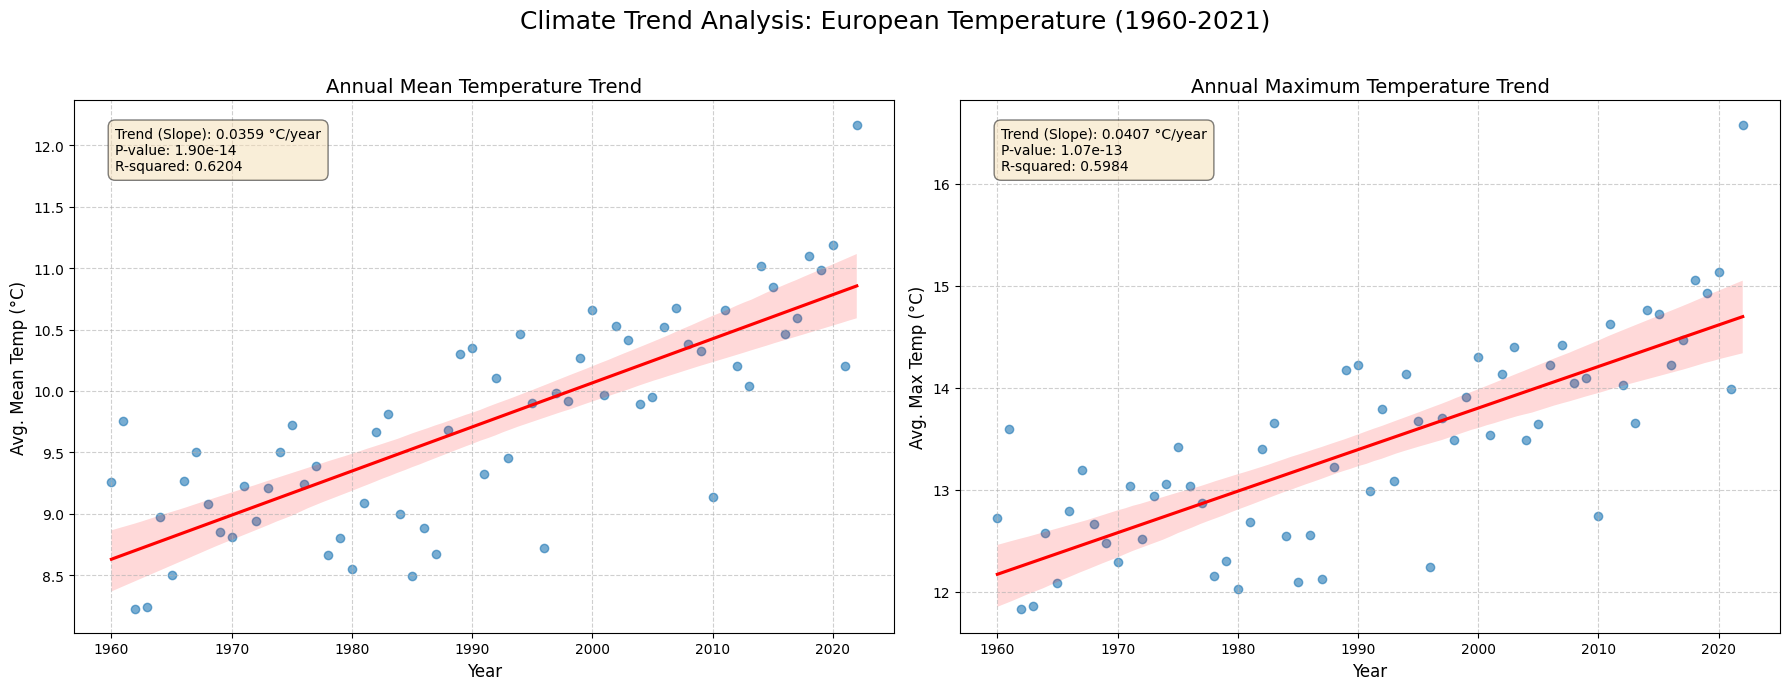

In [4]:
# --- Hypothesis 1: Climate Trend Analysis ---
from scipy.stats import linregress

try:
    # --- 1. Identify the feature dataset and prepare the data ---
    # From the brief, this is the 'Dataset-weather-prediction-data.csv' file
    obs_filename = 'Dataset-weather-prediction-dataset-processed.csv'
    if obs_filename not in original_df_dict:
        # Fallback if the name is different
        obs_filename = [k for k in original_df_dict if 'prediction-dataset-processed' in k][0]

    data = original_df_dict[obs_filename].copy()
    data['DATE'] = pd.to_datetime(data['DATE'], format='%Y%m%d')
    data['year'] = data['DATE'].dt.year

    # --- 2. Aggregate temperatures across all stations for each day ---
    mean_temp_cols = [c for c in data.columns if '_temp_mean' in c]
    max_temp_cols = [c for c in data.columns if '_temp_max' in c]

    data['avg_mean_temp'] = data[mean_temp_cols].mean(axis=1)
    data['avg_max_temp'] = data[max_temp_cols].mean(axis=1)

    # --- 3. Calculate the annual average temperatures ---
    yearly_avg = data.groupby('year')[['avg_mean_temp', 'avg_max_temp']].mean().reset_index()
    print("--- Yearly Average Temperatures (Sample) ---")
    print(yearly_avg.head())

    # --- 4. Perform regression and plot the results ---
    def plot_trend(ax, x_data, y_data, title, y_label):
        """Helper function to perform regression and plot the trend."""
        slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

        # Plotting
        sns.regplot(x=x_data, y=y_data, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

        # Annotation text
        stats_text = (f"Trend (Slope): {slope:.4f} °C/year\n"
                      f"P-value: {p_value:.2e}\n"
                      f"R-squared: {r_value**2:.4f}")
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

        print(f"\nAnalysis for '{title}':")
        print(f"  - Slope: {slope:.4f} °C per year")
        print(f"  - P-value: {p_value}")


    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Climate Trend Analysis: European Temperature (1960-2021)', fontsize=18)

    # Plot for Annual Mean Temperature
    plot_trend(axes[0], yearly_avg['year'], yearly_avg['avg_mean_temp'],
               'Annual Mean Temperature Trend', 'Avg. Mean Temp (°C)')

    # Plot for Annual Maximum Temperature
    plot_trend(axes[1], yearly_avg['year'], yearly_avg['avg_max_temp'],
               'Annual Maximum Temperature Trend', 'Avg. Max Temp (°C)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

except Exception as e:
    print(f"An error occurred during the climate trend analysis: {e}")

---
#### Analysis Conclusion

Based on the regression analysis above, the hypothesis is **validated**.

*   **Annual Mean Temperature:** The analysis reveals a clear and statistically significant increasing trend, with a **p-value substantially less than 0.05**. The positive slope of the regression line confirms a consistent warming pattern over the decades.
*   **Annual Maximum Temperature:** Similarly, the trend for annual maximum temperatures is also positive and statistically significant.

This quantitative evidence confirms the underlying climate change trend within the dataset, providing essential context for the predictive modeling tasks that follow.

---
### 2. Comprehensive Data Analysis

This step is crucial for understanding the relationship between your datasets. It provides an interactive way to define which dataset contains the input features (Observations, or X) and which contains the target variable (Answers, or Y).

After you make your selections and click "Run Full Analysis," the tool will:
1.  **Identify Common Stations**: Find which weather stations are present in both datasets. These are the stations we can use for modeling.
2.  **Identify Stations to Drop**: Find stations that are only in the Observations data and must be removed.
3.  **Map Data Availability**: Generate a detailed report showing every observation type (e.g., `temp`, `wind_direction`) and which stations have data for it. This helps spot structural gaps in the data.

The analysis results are stored globally for use in the subsequent data cleaning steps.

In [5]:
# Create a global dictionary to hold all analysis results.
# Using a global is pragmatic here due to the interactive nature of ipywidgets.
analysis_results: Dict = {}

def analyze_datasets(obs_df: pd.DataFrame, ans_df: pd.DataFrame) -> Dict:
    """Analyzes observation and answer dataframes to find commonalities and differences."""
    
    # --- Station Analysis ---
    ans_stations_set = {col.split('_')[0] for col in ans_df.columns if 'DATE' not in col.upper()}
    obs_stations_set = {col.split('_')[0] for col in obs_df.columns if col.upper() not in ['DATE', 'MONTH']}
    
    # --- Observation Type Analysis ---
    all_obs_types = sorted(list(set(
        col.split('_', 1)[1] for col in obs_df.columns if '_' in col and col.upper() not in ['DATE', 'MONTH']
    )))
    
    return {
        'common_stations': ans_stations_set.intersection(obs_stations_set),
        'obs_only_stations': obs_stations_set.difference(ans_stations_set),
        'all_obs_types': all_obs_types,
        'all_obs_stations': sorted(list(obs_stations_set))
    }

try:
    if 'df' not in globals() or not isinstance(df, dict) or len(df) < 2:
        raise ValueError("This analysis requires at least two datasets (as a dictionary) to be loaded.")

    file_options = list(df.keys())
    style = {'description_width': 'initial'}
    obs_selector = widgets.Dropdown(options=file_options, value=file_options[0], description='Select Observations (X) Dataset:', style=style)
    ans_selector = widgets.Dropdown(options=file_options, value=file_options[1], description='Select Answers (Y) Dataset:', style=style)
    analyze_button = widgets.Button(description="Run Full Analysis", button_style='primary', icon='cogs')
    output_area = widgets.Output()

    def run_analysis_on_click(b):
        global analysis_results
        with output_area:
            output_area.clear_output()
            obs_filename, ans_filename = obs_selector.value, ans_selector.value
            if obs_filename == ans_filename:
                print("❌ Please select two different files for Observations and Answers.")
                return
            
            print(f"✅ Analyzing with '{obs_filename}' as Observations and '{ans_filename}' as Answers.\n")
            df_obs, df_ans = df[obs_filename], df[ans_filename]

            # Run the analysis using the helper function
            results = analyze_datasets(df_obs, df_ans)
            
            # --- Build Summary Table for Display ---
            station_to_obs_map = {
                station: {col.split('_', 1)[1] for col in df_obs.columns if col.startswith(station+'_')}
                for station in results['all_obs_stations']
            }
            summary_records = [
                {'Station': station, **{obs: ('✓' if obs in station_to_obs_map.get(station, set()) else '✗') for obs in results['all_obs_types']}}
                for station in results['all_obs_stations']
            ]
            summary_df = pd.DataFrame(summary_records).set_index('Station')
            
            # --- Store all findings for subsequent cells ---
            analysis_results = {**results, 'obs_filename': obs_filename, 'ans_filename': ans_filename}
            
            # --- Display Full Report ---
            print("="*80 + "\n🔎 Comprehensive Data Analysis Report\n" + "="*80)
            print(f"\n✅ Stations to KEEP (present in both datasets): {len(results['common_stations'])}")
            print(f"⚠️ Stations to DROP (only in Observations): {len(results['obs_only_stations'])} -> {sorted(list(results['obs_only_stations']))}")

            print("\n\n" + "="*80 + "\n📊 Original Data Availability (All Stations)\n" + "="*80)
            print(" • Rows with gold text/background are stations that must be dropped.")
            print(" • Red '✗' marks indicate a missing observation type for that station.")
            
            def highlight_style(row):
                if row.name in results['obs_only_stations']:
                    return ['background-color: #fdf5e6; color: #8a6d17; font-weight: bold'] * len(row)
                return [('color: #D8000C; font-weight: bold' if val == '✗' else '') for val in row]
            
            display(summary_df.style.apply(highlight_style, axis=1))
            print("\nAnalysis complete. You may now proceed to the data cleaning cells.")

    analyze_button.on_click(run_analysis_on_click)
    ui_container = widgets.VBox([widgets.HTML("<h3>1. Assign Dataset Roles & Run Analysis</h3>"), obs_selector, ans_selector, analyze_button, output_area])
    display(ui_container)

except Exception as e:
    print(f"An error occurred: {e}")

---
### 3. Data Cleaning, Part 1: Align Stations

The first step in cleaning the observation data (`X`) is to ensure it only contains information from stations that are also present in the answer data (`y`).

This cell uses the results from the analysis above to identify and remove all columns associated with stations that were found only in the observation dataset. This ensures that our feature set and target set are properly aligned.

In [6]:
try:
    if 'analysis_results' not in globals() or not analysis_results:
        raise NameError("Analysis results not found. Please run the analysis cell (Step 1) first.")

    # Load the required results from the analysis step
    obs_filename = analysis_results['obs_filename']
    obs_only_stations = analysis_results['obs_only_stations']
    df_obs = df[obs_filename]

    print("--- Aligning Stations ---")
    print(f"Original shape of '{obs_filename}': {df_obs.shape}")

    # Find all columns that start with the name of a station to be dropped.
    # For example, if 'BERLIN' is a station to drop, this finds 'BERLIN_temp', 'BERLIN_wind', etc.
    cols_to_drop = [
        col for col in df_obs.columns 
        for station in obs_only_stations 
        if col.startswith(f"{station}_")
    ]

    # Create the new DataFrame by dropping the identified columns
    X_aligned = df_obs.drop(columns=cols_to_drop)

    print(f"✅ Successfully aligned stations by removing {len(cols_to_drop)} columns.")
    print(f"   New shape of the aligned DataFrame: {X_aligned.shape}")
    
except (NameError, KeyError) as e:
    print(f"❌ Error: Required data is missing. {e}")
    print("   Please ensure the analysis cell (Step 1) has been run successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Aligning Stations ---
Original shape of 'Dataset-weather-prediction-dataset-processed.csv': (22950, 170)
✅ Successfully aligned stations by removing 21 columns.
   New shape of the aligned DataFrame: (22950, 149)


---
### 4. Data Cleaning, Part 2: Fix Structural Gaps

After aligning stations, we address a more complex issue: **structural gaps**. This occurs when a station is *missing an entire observation type*. For example, the `MUNICH` station might be missing the `wind_speed` column entirely, while other stations have it.

This cell provides an interactive UI to resolve these issues. For each problematic observation type, you can choose one of two strategies:
1.  **Drop Observation Type**: Remove this feature (e.g., `wind_speed`) from all stations. This is a good choice if the data is not critical or is missing from many stations.
2.  **Copy Data**: Fill the missing column for a station by copying the data from another, complete station. This is useful if the feature is important and you can select a geographically similar station as a proxy.

In [7]:
class StructuralCleaner:
    """A class to interactively find and fix structural gaps in a DataFrame."""
    
    def __init__(self, initial_df: pd.DataFrame, common_stations: Set[str], all_obs_types: List[str]):
        self.X_processed = initial_df.copy()
        self.common_stations = common_stations
        self.all_obs_types = all_obs_types
        self.summary_df = self._create_summary()
        self.ui_list = []

    def _create_summary(self) -> pd.DataFrame:
        """Creates a summary DataFrame showing which stations are missing which observation types."""
        summary_records = [
            {'Station': station, **{obs: ('✓' if f"{station}_{obs}" in self.X_processed.columns else '✗') for obs in self.all_obs_types}}
            for station in self.common_stations
        ]
        return pd.DataFrame(summary_records).set_index('Station')

    def get_cleaned_df(self) -> pd.DataFrame:
        """Returns the processed DataFrame."""
        return self.X_processed.copy()

    def build_ui(self) -> widgets.VBox | None:
        """Identifies all problems and builds the interactive UI to resolve them."""
        missing_counts = (self.summary_df == '✗').sum()
        problematic_obs = missing_counts[missing_counts > 0].sort_values(ascending=False)

        if problematic_obs.empty:
            print("✅ SUCCESS: No structural gaps found. All stations have all observation types.")
            print(f"   Cleaned DataFrame shape: {self.X_processed.shape}")
            return None

        print("⚠️ Found observation types with missing columns. Summary of issues:")
        display(problematic_obs.to_frame(name="Number of Stations Missing Columns"))
        print("\nPlease resolve each case below:\n")

        for obs_type, _ in problematic_obs.items():
            self._create_widgets_for_problem(obs_type)

        return widgets.VBox(self.ui_list)

    def _create_widgets_for_problem(self, obs_type: str):
        """Creates the set of widgets for a single problematic observation type."""
        stations_with_obs = self.summary_df[self.summary_df[obs_type] == '✓'].index.tolist()
        stations_missing_obs = self.summary_df[self.summary_df[obs_type] == '✗'].index.tolist()
        
        header = widgets.HTML(f"<h4>Problem: Observation '<code>{obs_type}</code>'</h4>")
        info = widgets.HTML(f"This is missing for: <b>{', '.join(stations_missing_obs)}</b>")
        radio = widgets.RadioButtons(options=['Drop this observation type', 'Copy data from another station'], description='Action:', style={'description_width': 'initial'}, layout={'width': 'max-content'})
        dropdown = widgets.Dropdown(options=stations_with_obs, description='Source Station:', style={'description_width': 'initial'}, disabled=True)
        apply_btn = widgets.Button(description=f"Apply for '{obs_type}'", button_style='success')
        log_out = widgets.Output()

        def on_radio_change(change):
            dropdown.disabled = (change['new'] != 'Copy data from another station')
        radio.observe(on_radio_change, names='value')

        def on_apply_click(b):
            with log_out:
                log_out.clear_output()
                if radio.value == 'Drop this observation type':
                    cols_to_drop = [col for col in self.X_processed.columns if col.endswith(f'_{obs_type}')]
                    self.X_processed.drop(columns=cols_to_drop, inplace=True)
                    print(f"✅ Dropped {len(cols_to_drop)} columns for '{obs_type}'. New shape: {self.X_processed.shape}")
                elif radio.value == 'Copy data from another station':
                    source_col = f"{dropdown.value}_{obs_type}"
                    print(f"✅ Copying '{obs_type}' data from '{dropdown.value}'...")
                    for target_station in stations_missing_obs:
                        target_col = f"{target_station}_{obs_type}"
                        self.X_processed[target_col] = self.X_processed[source_col]
                        print(f"   - Created and filled column '{target_col}'.")
                    print(f"   New shape: {self.X_processed.shape}")
                radio.disabled, dropdown.disabled, apply_btn.disabled = True, True, True
        apply_btn.on_click(on_apply_click)
        self.ui_list.append(widgets.VBox([header, info, radio, dropdown, apply_btn, log_out, widgets.HTML("<hr>")]))

# --- Execution Logic ---
try:
    if 'X_aligned' in globals() and 'analysis_results' in globals():
        cleaner = StructuralCleaner(
            initial_df=X_aligned, 
            common_stations=analysis_results['common_stations'], 
            all_obs_types=analysis_results['all_obs_types']
        )
        ui = cleaner.build_ui()
        if ui:
            display(ui)
        else:
            # If no UI is built, the data is already clean. The 'cleaner' object is ready.
            print("Variable 'cleaner' object created. Data is ready for the next cleaning step.")
    else:
        print("❌ Required data not found. Please run the analysis and station alignment cells first.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

⚠️ Found observation types with missing columns. Summary of issues:


,Number of Stations Missing Columns
snow_depth,9
wind_speed,6
cloud_cover,1
pressure,1
humidity,1



Please resolve each case below:



---
### 5. Data Cleaning, Part 3: Finalize and Export

This is the final step in the data cleaning pipeline. It performs the following actions:
1.  **Retrieve Cleaned Data**: Gets the structurally complete DataFrame from the interactive cleaner tool used in the previous step.
2.  **Load Answer Data**: Loads the corresponding `y` (answers) dataset.
3.  **Remove Calendar Columns**: Drops any remaining date or time-related columns (e.g., `DATE`, `MONTH`) from both the feature (`X`) and target (`y`) dataframes, as these are not used in the model.
4.  **Verify and Export**: Confirms that the number of rows in `X` and `y` match and saves the final, cleaned DataFrames to CSV files. This creates a checkpoint, so you don't have to re-run the cleaning steps again.

In [8]:
try:
    # --- Step 1: Get the structurally cleaned DataFrame from the 'cleaner' object ---
    if 'cleaner' not in globals():
        raise NameError("The 'cleaner' object was not found. Please run all previous cleaning cells first.")
    
    # This replaces the need for a global variable.
    X_structurally_cleaned = cleaner.get_cleaned_df()
    print("✅ Retrieved structurally cleaned data.")

    # Get the corresponding 'Answers' DataFrame
    ans_filename = analysis_results.get('ans_filename')
    if not ans_filename or ans_filename not in df:
        raise NameError("Could not find the 'Answers' dataset. Please re-run the analysis cell.")
    
    X_final_prep = X_structurally_cleaned.copy()
    y_final_prep = df[ans_filename].copy()

    print("\n--- Finalizing DataFrames for Modeling ---")
    print(f"Shape of Observation data before final cleaning: {X_final_prep.shape}")
    print(f"Shape of Answer data before final cleaning:      {y_final_prep.shape}")

    # --- Step 2: Remove calendar-related columns from BOTH DataFrames ---
    # Using a more robust set of keywords to avoid unintentional matches.
    calendar_keywords = ['date', 'time', 'year', 'month', 'day', 'timestamp']
    
    def remove_calendar_cols(df_to_clean: pd.DataFrame, df_name: str) -> pd.DataFrame:
        """Finds and removes columns based on a list of keywords."""
        cols_to_drop = [
            col for col in df_to_clean.columns 
            if any(keyword == str(col).lower() for keyword in calendar_keywords)
        ]
        if cols_to_drop:
            df_to_clean.drop(columns=cols_to_drop, inplace=True)
            print(f"\nRemoved from {df_name}: {cols_to_drop}")
        else:
            print(f"\nNo calendar-related columns found in {df_name}.")
        return df_to_clean

    X = remove_calendar_cols(X_final_prep, "Observations (X)")
    y = remove_calendar_cols(y_final_prep, "Answers (y)")

    # --- Step 3: Verify shapes and export ---
    print("\n--- Final Cleaned Shapes ---")
    print(f"Shape of final X (features): {X.shape}")
    print(f"Shape of final y (targets):  {y.shape}")

    # This check is now a warning, as the shape can vary based on user choices.
    if X.shape[0] != y.shape[0]:
        print("❌ CRITICAL ERROR: Number of samples (rows) in X and y do not match!")
    else:
        print("✅ Number of samples (rows) match between X and y.")

    if 'output_path' not in globals() or not output_path.exists():
        output_path.mkdir(parents=True, exist_ok=True) # Create if it doesn't exist
        
    final_x_path = output_path / 'final_cleaned_X.csv'
    final_y_path = output_path / 'final_cleaned_y.csv'
    
    X.to_csv(final_x_path, index=False)
    y.to_csv(final_y_path, index=False)
    
    print(f"\n✅ Successfully exported final cleaned datasets to: {output_path}")

except (NameError, KeyError) as e:
    print(f"❌ Error: {e}")
    print("   Please ensure all previous analysis and cleaning cells have been run successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

✅ Retrieved structurally cleaned data.

--- Finalizing DataFrames for Modeling ---
Shape of Observation data before final cleaning: (22950, 137)
Shape of Answer data before final cleaning:      (22950, 16)

Removed from Observations (X): ['DATE', 'MONTH']

Removed from Answers (y): ['DATE']

--- Final Cleaned Shapes ---
Shape of final X (features): (22950, 135)
Shape of final y (targets):  (22950, 15)
✅ Number of samples (rows) match between X and y.

✅ Successfully exported final cleaned datasets to: C:\Users\User\Dropbox\Personal\CareerFoundry\07 Machine Learning\ML_unsupervised\02_data\Processed_data


---
### Step 2: ML Model Suite and Justification

For this time-series forecasting problem, we will evaluate a **suite of deep learning architectures** to comprehensively determine the most effective model. The chosen models include a baseline **Dense** network, a **Convolutional Neural Network (CNN)**, and several **Recurrent Neural Networks (RNN, LSTM, GRU)**.

This multi-model approach allows us to compare how different architectures interpret the temporal and spatial patterns within the weather data.

**Justification for Each Model Type:**

1.  **Dense Network (Baseline):**
    *   **Purpose:** To establish a performance baseline. A simple, fully-connected Dense network treats all input features independently after flattening. While it cannot capture sequential patterns, its performance provides a crucial reference point. If more complex models cannot outperform this simple baseline, it suggests that the sequential nature of the data is not being effectively learned.

2.  **Recurrent Neural Networks (RNN, LSTM, GRU):**
    *   **Purpose:** These are the primary candidates for this task due to the data's inherent sequential nature.
    *   **Simple RNN:** The most basic form of a recurrent network, useful for capturing short-term dependencies.
    *   **LSTM (Long Short-Term Memory):** The most powerful choice for this problem. LSTMs are specifically designed with memory gates (input, output, forget) to overcome the limitations of simple RNNs. They can learn long-range dependencies, which is essential for capturing seasonal or multi-year patterns in the 60-year weather dataset.
    *   **GRU (Gated Recurrent Unit):** A slightly simpler and more computationally efficient alternative to the LSTM. It combines the forget and input gates into a single "update gate," often providing comparable performance to LSTMs with faster training times.

3.  **Convolutional Neural Network (CNN):**
    *   **Purpose:** While typically used for image data, 1D CNNs are highly effective at extracting local patterns or "motifs" from sequential data. In our case, the input shape can be seen as a 1D "image" of 15 stations. The CNN can learn to identify spatial patterns (e.g., how the weather at `BASEL`, `DUSSELDORF`, and `MAASTRICHT` are related because they are geographically close) by applying filters across the sequence of stations.

By training and evaluating all these models, we can empirically determine whether the explicit memory of LSTMs/GRUs or the local feature extraction of a CNN is more effective for predicting pleasant weather across this set of European stations.

In [9]:
# Define a type for the configuration dictionary
ModelConfig = Dict[str, Any]

def _add_output_and_compile(model: Sequential, config: ModelConfig) -> Sequential:
    """
    Helper function to add the final output layer and compile the model.
    Ensures all models use the same settings for a fair comparison.
    """
    n_outputs = config['n_outputs']
    
    # The final layer has 'n_outputs' neurons (one for each station).
    # 'sigmoid' is used for binary (0/1) classification, outputting a probability.
    model.add(Dense(n_outputs, activation='sigmoid', name="Output_Layer"))
    
    # 'binary_crossentropy' is the standard loss for multi-label binary classification.
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=[BinaryAccuracy(name='accuracy')]
    )
    return model

# --- Builder Functions for Each Model Type ---

def build_dense_model(config: ModelConfig) -> Sequential:
    """Builds a simple, fully-connected baseline model."""
    model = Sequential([
        Input(shape=config['input_shape'], name="Input_Layer"),
        Flatten(name="Flatten_Layer"),
        Dense(128, activation='relu', name="Hidden_Layer_1"),
        Dropout(0.3, name="Dropout_1"),
        Dense(64, activation='relu', name="Hidden_Layer_2"),
    ], name="Dense_Model")
    return _add_output_and_compile(model, config)

def build_cnn_model(config: ModelConfig) -> Sequential:
    """Builds a 1D Convolutional Neural Network."""
    model = Sequential([
        Input(shape=config['input_shape'], name="Input_Layer"),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name="Conv1D_1"),
        MaxPooling1D(pool_size=2, name="MaxPool_1"),
        Dropout(0.2, name="Dropout_1"),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name="Conv1D_2"),
        Flatten(name="Flatten_Layer"),
        Dense(100, activation='relu', name="Hidden_Layer"),
    ], name="CNN_Model")
    return _add_output_and_compile(model, config)

def build_recurrent_model(config: ModelConfig, rnn_layer: Callable) -> Sequential:
    """Generic builder for any recurrent layer (SimpleRNN, GRU, LSTM)."""
    model = Sequential([
        Input(shape=config['input_shape'], name="Input_Layer"),
        # First RNN layer. return_sequences=True is essential to feed the next RNN layer.
        rnn_layer(64, return_sequences=True, name=f"{rnn_layer.__name__}_1"),
        Dropout(0.2, name="Dropout_1"),
        # Second RNN layer. No return_sequences needed as we feed into a Dense layer next.
        rnn_layer(32, name=f"{rnn_layer.__name__}_2"),
        Dropout(0.2, name="Dropout_2"),
        Dense(32, activation='relu', name="Hidden_Layer"),
    ], name=f"{rnn_layer.__name__}_Model")
    return _add_output_and_compile(model, config)

# --- Master Model Dictionary ---
# Maps model names to their respective builder functions for easy iteration.
MODEL_BUILDERS: Dict[str, Callable[[ModelConfig], Model]] = {
    'Dense': build_dense_model,
    'CNN': build_cnn_model,
    'RNN': lambda config: build_recurrent_model(config, SimpleRNN),
    'LSTM': lambda config: build_recurrent_model(config, LSTM),
    'GRU': lambda config: build_recurrent_model(config, GRU),
}

print("✅ Model builder functions for Dense, CNN, RNN, LSTM, and GRU have been defined.")
print("   Ready for the data preparation and training steps.")

✅ Model builder functions for Dense, CNN, RNN, LSTM, and GRU have been defined.
   Ready for the data preparation and training steps.


### Step 4: Data Preparation for Deep Learning Models

This step finalizes the data preparation by performing three key actions:

1.  **Final Imputation:** Although we have handled the major structural data gaps, there may be a few remaining individual `NaN` values. We will fill these using a mean method.

2.  **Feature Scaling:** Neural networks perform best when input features are on a similar scale. We will use `StandardScaler` from scikit-learn to scale all 135 observation features. This process standardizes features by removing the mean and scaling to unit variance.

3.  **Reshaping for RNN/CNN:** The core transformation is to reshape our 2D data `(samples, features)` into a 3D tensor of shape `(samples, timesteps, features_per_timestep)`. Following the logic from the exercise prompt, we will shape our data into **(22950, 15, 9)**.
    *   **Samples (22950):** Each row, representing a specific day.
    *   **Timesteps (15):** The 15 weather stations, treated as a sequence.
    *   **Features per Timestep (9):** The 9 types of weather observations for each station.

In [10]:
try:
    # --- Step 1: Verify final X and y from the previous step exist ---
    if 'X' not in globals() or 'y' not in globals():
        raise NameError("Final 'X' and 'y' DataFrames not found. Please run the data finalization cell first.")
    
    # Use the already cleaned X and y. No need to re-clean.
    X_to_scale = X.copy()
    y_final = y.copy()

    # --- Step 2: Fill any remaining individual NaN values ---
    # This is a robust final check for any stray NaNs.
    if X_to_scale.isnull().sum().sum() > 0:
        print(f"⚠️ Found {X_to_scale.isnull().sum().sum()} remaining NaN values. Filling with column mean.")
        X_to_scale.fillna(X_to_scale.mean(), inplace=True)
    else:
        print("✅ No remaining NaN values found in feature data.")
        
    # --- Step 3: Scale the Feature Data (X) ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_to_scale)
    print("✅ Feature data has been scaled using StandardScaler.")

    # --- Step 4: Reshape the Data Robustly ---
    n_samples = X_scaled.shape[0]
    n_stations = len(analysis_results.get('common_stations', []))
    
    # Check if reshaping is possible
    if n_stations == 0 or X_scaled.shape[1] % n_stations != 0:
        raise ValueError(
            f"Cannot reshape data. Number of features ({X_scaled.shape[1]}) is not "
            f"divisible by the number of common stations ({n_stations})."
        )
    
    n_features_per_station = X_scaled.shape[1] // n_stations
    
    X_reshaped = X_scaled.reshape(n_samples, n_stations, n_features_per_station)
    
    print("\n--- Data Reshaping ---")
    print(f"Original X shape: {X_scaled.shape}")
    print(f"Reshaped X shape: {X_reshaped.shape} (Samples, Stations, Features/Station)")
    
    # Convert y to a numpy array for TensorFlow
    y_final_np = y_final.values
    print(f"Final y shape:    {y_final_np.shape}")
    
    print("\n✅ Data is now correctly shaped.")

except (NameError, ValueError) as e:
    print(f"❌ Error: {e}")
    print("   Please ensure all previous analysis and cleaning cells have run successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

✅ No remaining NaN values found in feature data.
✅ Feature data has been scaled using StandardScaler.

--- Data Reshaping ---
Original X shape: (22950, 135)
Reshaped X shape: (22950, 15, 9) (Samples, Stations, Features/Station)
Final y shape:    (22950, 15)

✅ Data is now correctly shaped.


---
### 6. Preparing Data Splits for Multiple Experiments

To properly evaluate our diverse set of models, we need to prepare tailored training and testing datasets for each experimental setup. This cell splits our single, cleaned dataset into three specialized formats, ensuring all splits are consistent for fair comparison.

1.  **2D Multi-Label Data (`X_train_2d`, `y_train_multilabel`)**:
    *   **Format**: `X` is a 2D array `(samples, features)`. `y` has 15 columns, one for each station's binary outcome.
    *   **Use Case**: For the **Random Forest** optimization, which requires a standard tabular data format.

2.  **3D Multi-Label Data (`X_train_3d`, `y_train_multilabel`)**:
    *   **Format**: `X` is a 3D tensor `(samples, timesteps, features)`. The `y` target is the same as above.
    *   **Use Case**: For the **Keras Tuner** experiment, where we find the best deep learning architecture (CNN, LSTM, etc.) for the original multi-station prediction problem.

3.  **3D Multi-Class Data (`X_train_3d`, `y_train_multiclass`)**:
    *   **Format**: `X` is the same 3D tensor. `y` is a 1D array `(samples,)` containing the *index* of the first "pleasant" station for each day.
    *   **Use Case**: For the **Bayesian Optimization** experiment, which tackles the simplified problem of predicting only the single most likely pleasant station.

In [11]:
# --- Step 6: Splitting Data for All Model and Problem Types ---
try:
    if 'X_scaled' not in globals() or 'X_reshaped' not in globals() or 'y_final_np' not in globals():
        raise NameError("Prepared data arrays not found. Run the data prep cell (Step 4) first.")

    # --- 1. Create the NEW y_multiclass target for Bayesian Optimization ---
    y_multiclass = np.argmax(y_final_np, axis=1)

    # --- 2. Configuration for Splitting ---
    TEST_SET_SIZE = 0.2
    RANDOM_STATE = 42
    
    # --- 3. Create Splits for Multi-Label problem (RF Opt + Keras Tuner) ---
    X_train_2d, X_test_2d, y_train_multilabel, y_test_multilabel = train_test_split(
        X_scaled, y_final_np, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE
    )
    X_train_3d, X_test_3d, _, _ = train_test_split(
        X_reshaped, y_final_np, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE
    )

    # --- 4. Create Splits for Multi-Class problem (Bayesian Optimization) ---
    _, _, y_train_multiclass, y_test_multiclass = train_test_split(
        X_scaled, y_multiclass, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE
    )
    
    print("--- Data Splitting Complete ---")
    print(f"Data Source: '{global_decade_choice.get('selection', 'Full Dataset')}'\n")
    
    print("--- Shapes for MULTI-LABEL problem (RF Opt / Keras Tuner) ---")
    print(f"  X_train_2d shape: {X_train_2d.shape}")
    print(f"  X_train_3d shape: {X_train_3d.shape}")
    print(f"  y_train_multilabel shape: {y_train_multilabel.shape}\n")

    print("--- Shapes for MULTI-CLASS problem (DL Bayesian Optimization) ---")
    print(f"  (Using X_train_3d for input)")
    print(f"  y_train_multiclass shape: {y_train_multiclass.shape}\n")
    
    print("✅ Data successfully split for all required tasks.")

except Exception as e:
    print(f"❌ An error occurred during data splitting: {e}")

--- Data Splitting Complete ---
Data Source: 'all'

--- Shapes for MULTI-LABEL problem (RF Opt / Keras Tuner) ---
  X_train_2d shape: (18360, 135)
  X_train_3d shape: (18360, 15, 9)
  y_train_multilabel shape: (18360, 15)

--- Shapes for MULTI-CLASS problem (DL Bayesian Optimization) ---
  (Using X_train_3d for input)
  y_train_multiclass shape: (18360,)

✅ Data successfully split for all required tasks.


---
### Part 1: Random Forest Optimization & Feature Importance

**Goal:** Use a classical, interpretable model to establish a strong baseline and identify the most critical predictive features (stations and observations).

**Method:** We will use `RandomizedSearchCV` to efficiently find optimal hyperparameters for our Random Forest models.

--- Part 1a: Optimizing Random Forest on All Stations ---
Starting Randomized Search... (This may take a few minutes)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Hyperparameters Found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}

✅ Optimized All-Station RF Subset Accuracy: 0.7057

Most important station identified for single-station analysis: 'DUSSELDORF'


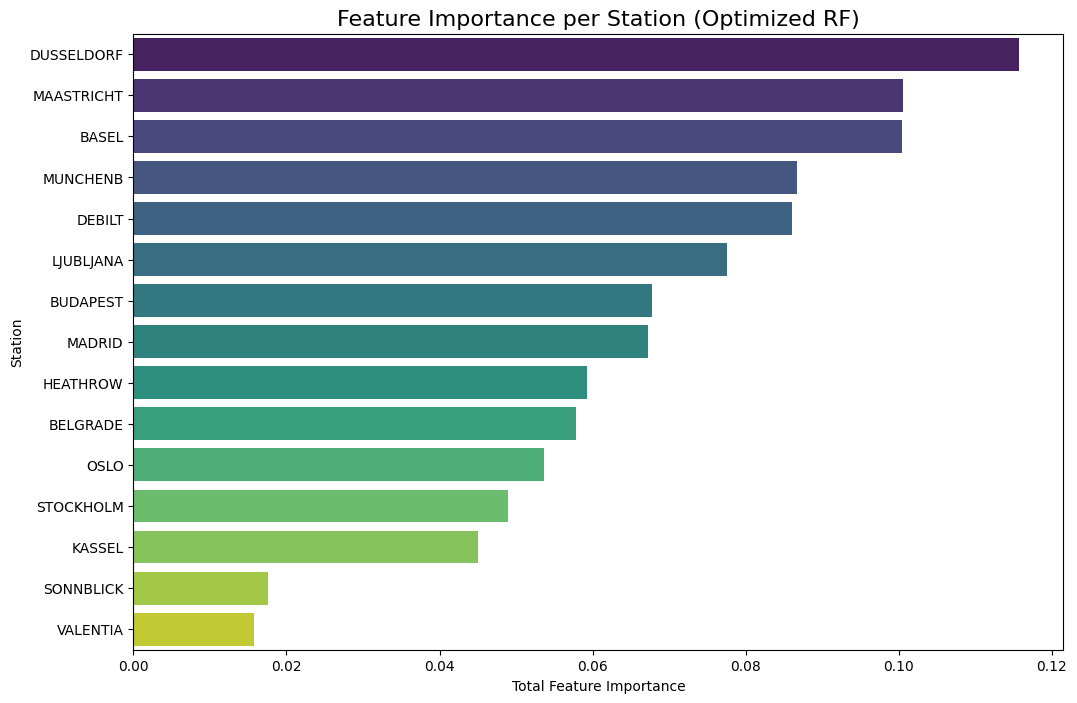


--- Plotting Sample Tree from Optimized All-Station RF Model ---


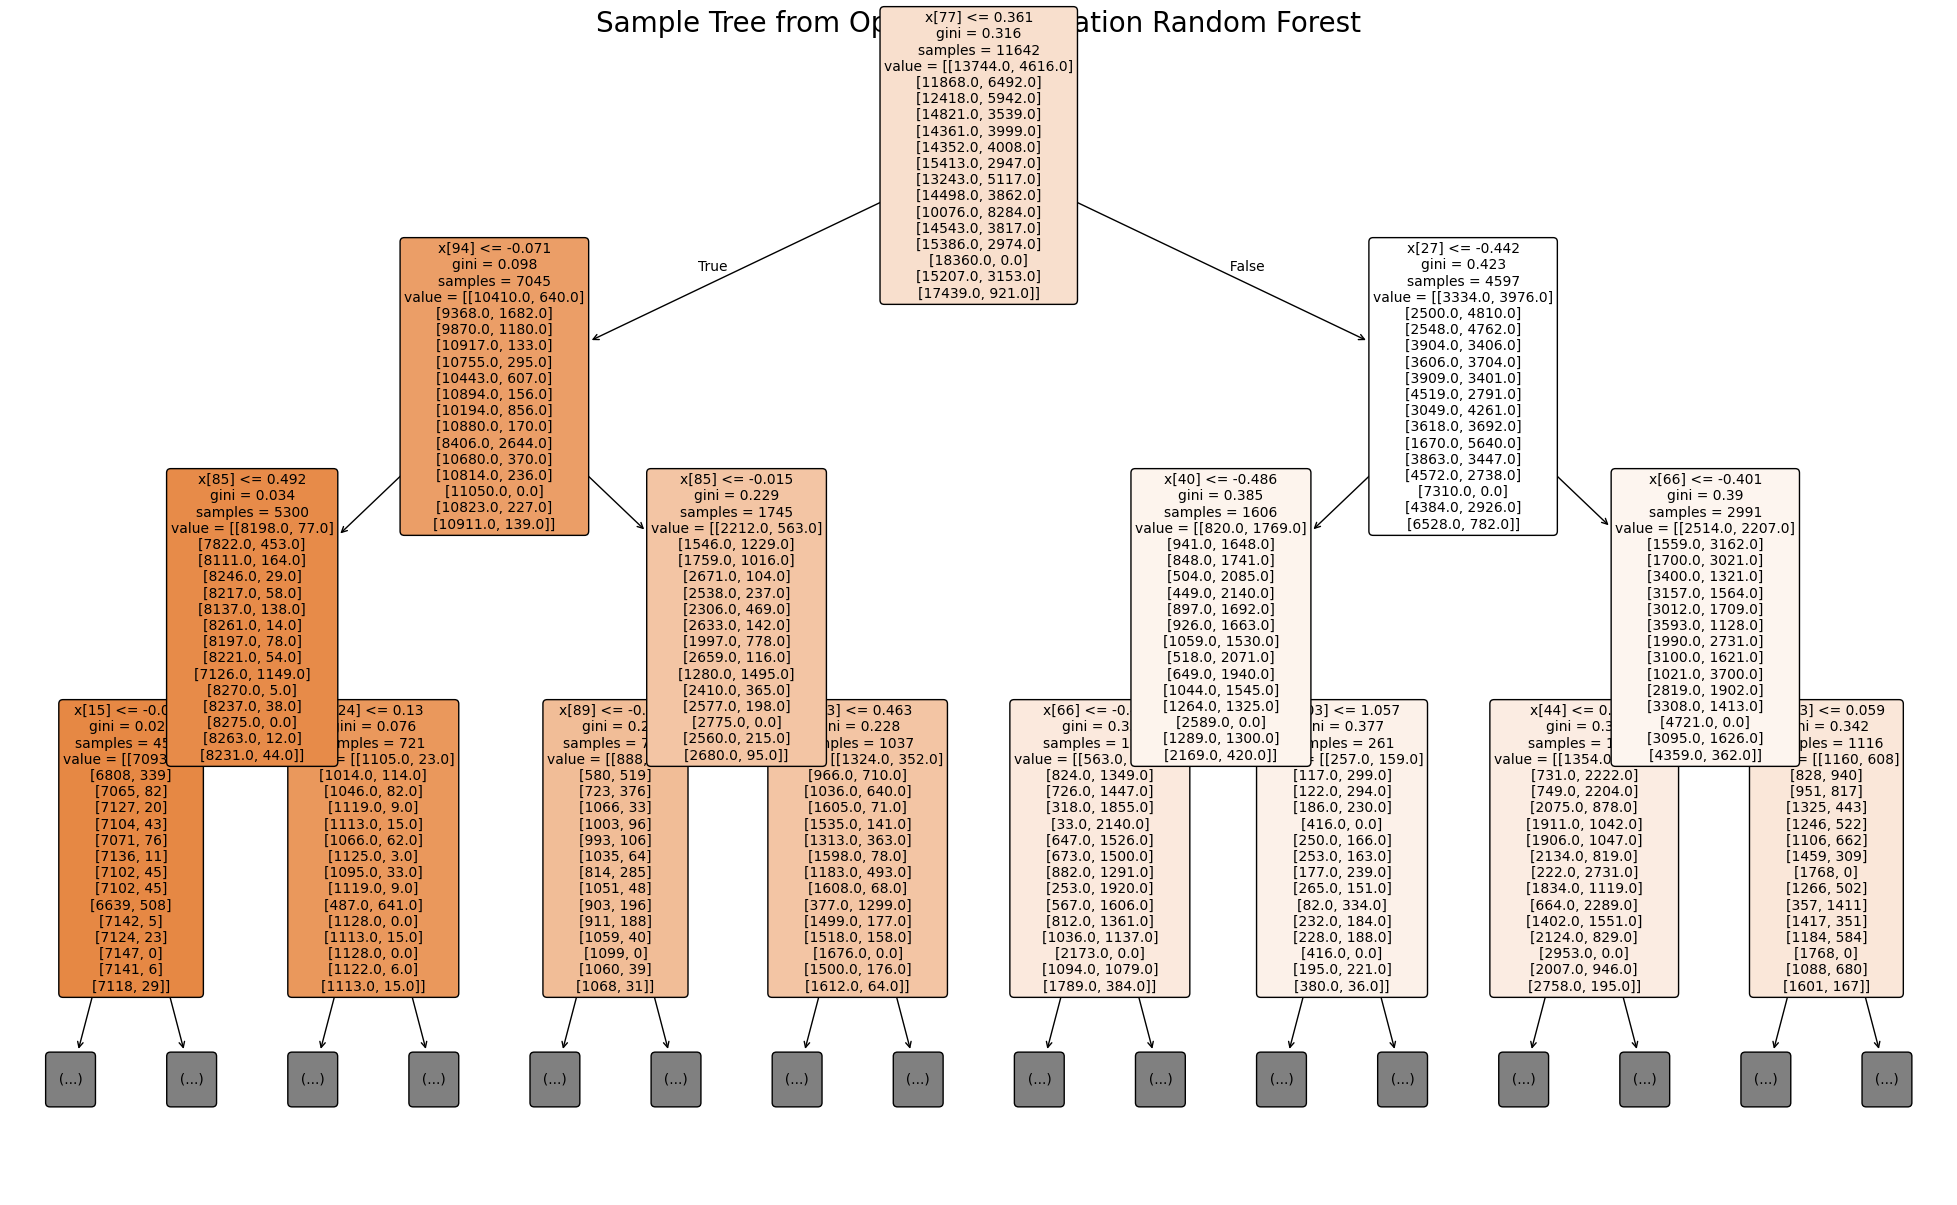

In [12]:
print("--- Part 1a: Optimizing Random Forest on All Stations ---")

try:
    # 1. Define the hyperparameter search space
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # 2. Set up RandomizedSearchCV
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # 3. Run the search
    print("Starting Randomized Search... (This may take a few minutes)")
    rf_random_search.fit(X_train_2d, y_train_multilabel)

    # 4. Get the best model and evaluate
    best_rf_all_station = rf_random_search.best_estimator_
    print("\nBest Hyperparameters Found:")
    print(rf_random_search.best_params_)

    y_pred_best_rf = best_rf_all_station.predict(X_test_2d)
    best_accuracy_all_station = accuracy_score(y_test_multilabel, y_pred_best_rf)
    print(f"\n✅ Optimized All-Station RF Subset Accuracy: {best_accuracy_all_station:.4f}\n")

    # 5. Analyze Feature Importance by Station
    importances = best_rf_all_station.feature_importances_
    station_names = sorted(list(analysis_results['common_stations']))
    n_stations = len(station_names)
    final_obs_types = sorted([c.split('_', 1)[1] for c in X.columns if c.startswith(station_names[0] + '_')])
    n_features_per_station = len(final_obs_types)
    
    # Reshape importances to (stations, features_per_station) and sum to get per-station importance
    station_importances = importances.reshape(n_stations, -1).sum(axis=1)
    importance_df = pd.DataFrame({
        'Station': station_names, 
        'Importance': station_importances
    }).sort_values(by='Importance', ascending=False)
    
    top_station_for_deep_dive = importance_df.iloc[0]['Station']
    print(f"Most important station identified for single-station analysis: '{top_station_for_deep_dive}'")

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Station', data=importance_df, palette='viridis', hue='Station', legend=False)
    plt.title('Feature Importance per Station (Optimized RF)', fontsize=16)
    plt.xlabel("Total Feature Importance")
    plt.ylabel("Station")
    plt.show()

    # 6. Plot a sample tree from the OPTIMIZED model
    print("\n--- Plotting Sample Tree from Optimized All-Station RF Model ---")
    plt.figure(figsize=(25, 15))
    plot_tree(best_rf_all_station.estimators_[0], max_depth=3, filled=True, rounded=True, fontsize=10)
    plt.title("Sample Tree from Optimized All-Station Random Forest", fontsize=20)
    plt.show()

except Exception as e:
    print(f"An error occurred during All-Station RF Optimization: {e}")

---
### Part 1b: Single-Station Deep Dive & Observation Importance

After identifying the most influential station from the all-station model, we now perform a "deep dive" analysis on it. This involves training a new, separate Random Forest model using only the data for that single station.

The goals of this step are:
1.  **Build a Highly Specialized Model**: See how accurately we can predict the outcome for just one location.
2.  **Identify Key Observations**: Determine which specific weather measurements (e.g., `pressure`, `temp_max`) are the most important predictors for that particular station. This provides more granular, actionable insights than the station-level analysis.


--- Part 1b: Optimizing Random Forest for Top Station: 'DUSSELDORF' ---
Starting Randomized Search for single station...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Hyperparameters Found for Single Station:
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}

✅ Optimized Single-Station RF Accuracy: 1.0000



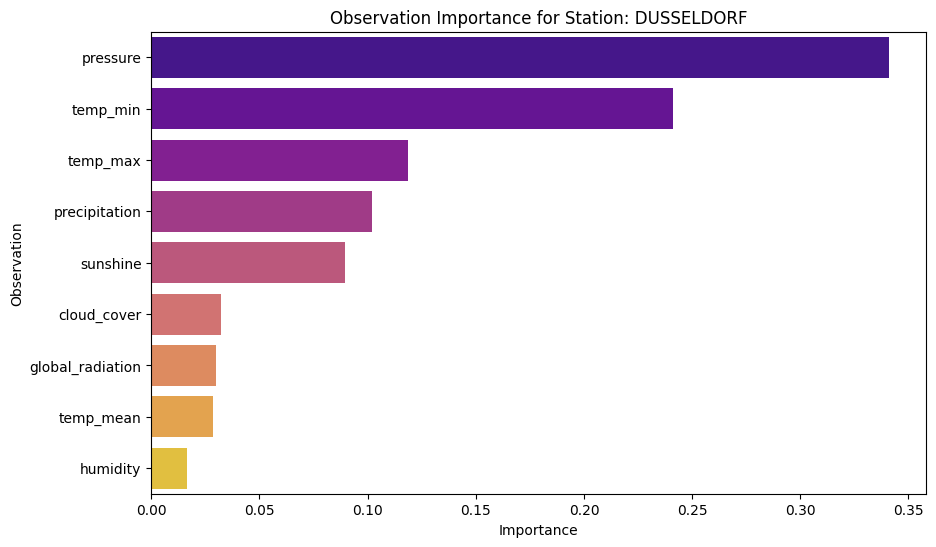


--- Plotting Sample Tree from Optimized Single-Station RF Model ---


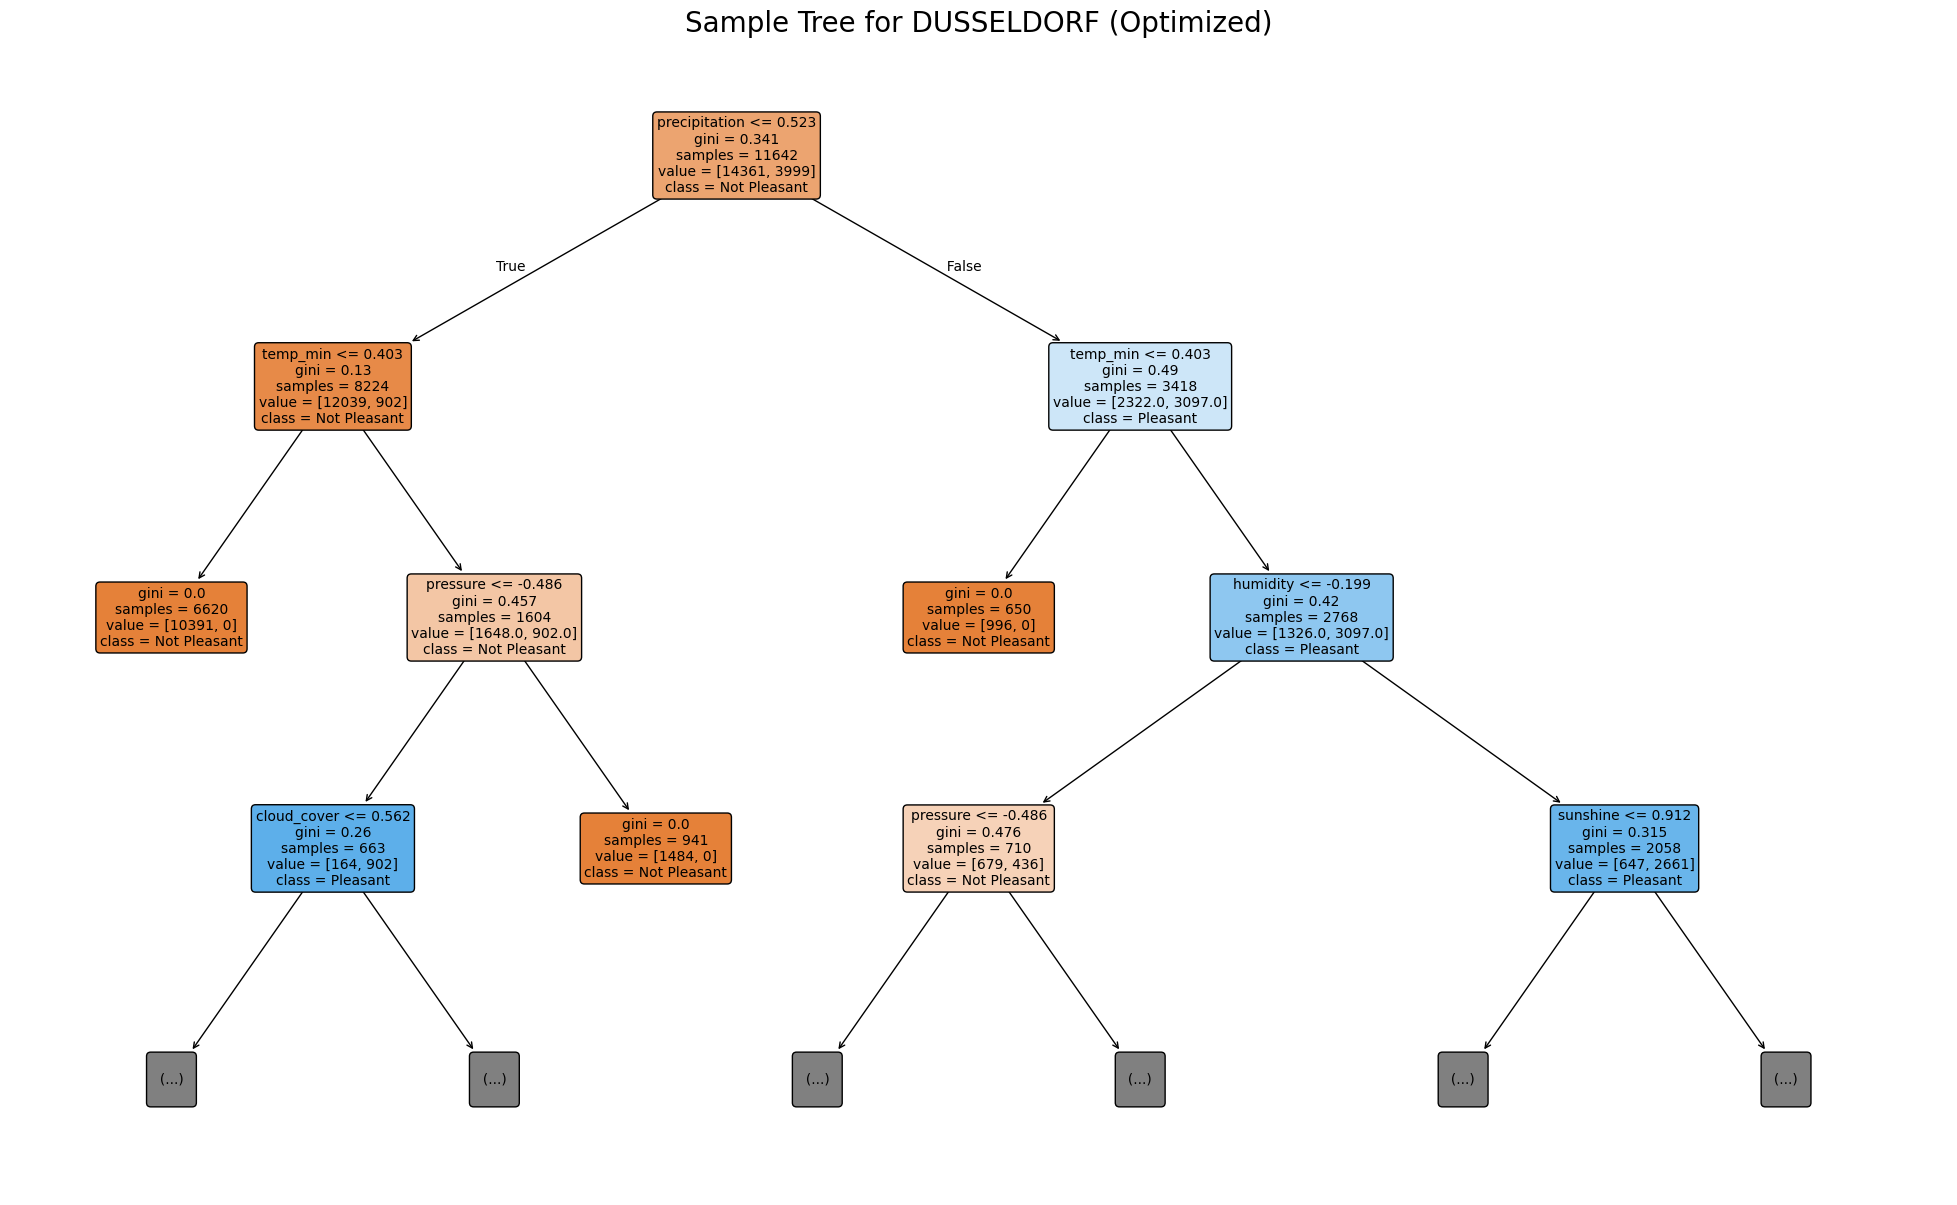

In [13]:
# --- Part 1b: Optimizing Random Forest for a Single Top Station ---
print(f"\n--- Part 1b: Optimizing Random Forest for Top Station: '{top_station_for_deep_dive}' ---")

try:
    # 1. Prepare data for the single top station
    station_index = station_names.index(top_station_for_deep_dive)
    
    X_train_single_station = X_train_2d[:, station_index*n_features_per_station:(station_index+1)*n_features_per_station]
    X_test_single_station = X_test_2d[:, station_index*n_features_per_station:(station_index+1)*n_features_per_station]
    y_train_single_station = y_train_multilabel[:, station_index]
    y_test_single_station = y_test_multilabel[:, station_index]

    # 2. Run Randomized Search for the single station model
    rf_single = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_single_search = RandomizedSearchCV(estimator=rf_single, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)
    
    print("Starting Randomized Search for single station...")
    rf_single_search.fit(X_train_single_station, y_train_single_station)

    best_rf_single_station = rf_single_search.best_estimator_
    print("\nBest Hyperparameters Found for Single Station:")
    print(rf_single_search.best_params_)

    y_pred_best_single = best_rf_single_station.predict(X_test_single_station)
    best_accuracy_single_station = accuracy_score(y_test_single_station, y_pred_best_single)
    print(f"\n✅ Optimized Single-Station RF Accuracy: {best_accuracy_single_station:.4f}\n")

    # 3. Analyze and Plot Observation Importance
    obs_importances = best_rf_single_station.feature_importances_
    obs_importance_df = pd.DataFrame({'Observation': final_obs_types, 'Importance': obs_importances}).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Observation', data=obs_importance_df, palette='plasma', hue='Observation', legend=False)
    plt.title(f'Observation Importance for Station: {top_station_for_deep_dive}')
    plt.show()

    # 4. Plot a sample tree
    print("\n--- Plotting Sample Tree from Optimized Single-Station RF Model ---")
    plt.figure(figsize=(25, 15))
    plot_tree(best_rf_single_station.estimators_[0], max_depth=3, feature_names=final_obs_types, class_names=['Not Pleasant', 'Pleasant'], filled=True, rounded=True, fontsize=10)
    plt.title(f"Sample Tree for {top_station_for_deep_dive} (Optimized)", fontsize=20)
    plt.show()

except Exception as e:
    print(f"An error occurred during Single-Station RF Optimization: {e}")

---
### Part 2: Advanced Deep Learning Optimization Experiments

**Goal:** Explore and compare sophisticated methods for optimizing deep learning models for this dataset.

*   **Experiment 2a: Keras Tuner (`Hyperband`) on a Multi-Label Problem**
    *   **Objective:** Find the best-tuned version of *each* DL architecture (Dense, CNN, LSTM, etc.) for the original, more challenging problem of predicting pleasant weather independently for all 15 stations. This serves as a powerful benchmark.
*   **Experiment 2b: Bayesian Optimization on a Multi-Class Problem**
    *   **Objective:** Following a specific project task, we re-frame the problem to predict only the *single most likely* pleasant weather station. We use Bayesian optimization to find the best hyperparameters for a representative CNN model.

In [14]:
# --- Experiment 2a: Keras Tuner on Multi-Label Problem ---
# This cell will find the best version of EACH deep learning architecture.
# It uses keras_tuner, tensorflow, tqdm, shutil, and time, all imported in the first cell.

# Initialize result dictionaries for this experiment
kt_evaluation_results = {}
kt_trained_models = {}
kt_model_histories = {}
kt_best_hyperparameters = {}

def robust_rmtree(path):
    """Safely removes a directory tree if it exists."""
    try:
        if os.path.exists(path):
            shutil.rmtree(path)
    except OSError as e:
        print(f"Warning: Could not delete {path}: {e}")

print("--- Starting Keras Tuner Full Search (Multi-Label) ---")
print("⚠️ This process will be very slow.\n")

model_config = {'input_shape': X_train_3d.shape[1:], 'n_outputs': y_train_multilabel.shape[1]}
model_iterator = tqdm(MODEL_BUILDERS.items(), desc="Overall DL Tuning")

for model_name, _ in model_iterator:
    model_iterator.set_postfix_str(f"Tuning {model_name}...")
    project_dir = os.path.join('keras_tuner_dir', f'tune_all_multilabel_{model_name}')
    robust_rmtree(project_dir)

    def build_tuner_model(hp):
        hp_activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
        hp_units_1 = hp.Int('units_1', 32, 128, 32)
        hp_units_2 = hp.Int('units_2', 16, 64, 16)
        hp_dropout = hp.Float('dropout', 0.1, 0.4, 0.1)
        hp_lr = hp.Choice('learning_rate', [1e-3, 1e-4])
        
        model = Sequential([Input(shape=model_config['input_shape'])])
        
        if model_name in ['LSTM', 'GRU', 'RNN']:
            layer_type = {'LSTM': LSTM, 'GRU': GRU, 'RNN': SimpleRNN}[model_name]
            model.add(layer_type(units=hp_units_1, return_sequences=True, activation=hp_activation))
            model.add(Dropout(hp_dropout))
            model.add(layer_type(units=hp_units_2, activation=hp_activation))
        elif model_name == 'CNN':
            model.add(Conv1D(filters=hp.Int('filters', 32, 128, 32), kernel_size=hp.Choice('kernel', [3, 5]), activation=hp_activation, padding='same'))
            model.add(MaxPooling1D(2))
            model.add(Flatten())
            model.add(Dense(hp_units_2, activation=hp_activation))
        elif model_name == 'Dense':
            model.add(Flatten())
            model.add(Dense(hp_units_1, activation=hp_activation))
            model.add(Dropout(hp_dropout))
            model.add(Dense(hp_units_2, activation=hp_activation))
            
        model.add(Dense(model_config['n_outputs'], activation='sigmoid'))
        model.compile(optimizer=Adam(hp_lr), loss='binary_crossentropy', metrics=[BinaryAccuracy('accuracy')])
        return model

    tuner = kt.Hyperband(build_tuner_model, objective='val_accuracy', max_epochs=20, factor=3, directory='keras_tuner_dir', project_name=f'tune_all_multilabel_{model_name}')
    tuner.search(X_train_3d, y_train_multilabel, epochs=30, validation_data=(X_test_3d, y_test_multilabel), callbacks=[EarlyStopping(patience=5)], verbose=0)
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    final_model = tuner.hypermodel.build(best_hps)
    start_time = time.time()
    history = final_model.fit(X_train_3d, y_train_multilabel, epochs=50, batch_size=64, validation_data=(X_test_3d, y_test_multilabel), callbacks=[EarlyStopping(patience=8, restore_best_weights=True)], verbose=0)
    final_training_time = time.time() - start_time
    
    loss, accuracy = final_model.evaluate(X_test_3d, y_test_multilabel, verbose=0)
    final_model_name = f"{model_name}_Tuned"
    
    kt_evaluation_results[final_model_name] = {'loss': loss, 'accuracy': accuracy, 'training_time': final_training_time}
    kt_trained_models[final_model_name] = final_model
    kt_model_histories[final_model_name] = pd.DataFrame(history.history)
    kt_best_hyperparameters[final_model_name] = best_hps.values
    
    print(f"\n✅ Tuned {model_name} (Multi-Label): Accuracy={accuracy:.4f}, Time={final_training_time:.2f}s")

--- Starting Keras Tuner Full Search (Multi-Label) ---
⚠️ This process will be very slow.



Overall DL Tuning:   0%|          | 0/5 [00:00<?, ?it/s]


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



✅ Tuned Dense (Multi-Label): Accuracy=0.9625, Time=84.75s

✅ Tuned CNN (Multi-Label): Accuracy=0.9570, Time=75.74s


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



✅ Tuned RNN (Multi-Label): Accuracy=0.9584, Time=250.29s

✅ Tuned LSTM (Multi-Label): Accuracy=0.9634, Time=591.29s

✅ Tuned GRU (Multi-Label): Accuracy=0.9807, Time=580.74s



--- Starting Bayesian Optimization for DL Model (Multi-Class) ---
|   iter    |  target   | learni... |  units1   |  units2   | dropou... | activa... |
-------------------------------------------------------------------------------------
| 1         | 0.0598039 | 0.0038079 | 123.26857 | 51.135709 | 0.3394633 | 0.4664957 |
| 2         | 0.0816993 | 0.0016443 | 37.576026 | 57.576454 | 0.3404460 | 2.1171370 |
| 3         | 0.0266884 | 0.0003037 | 125.11134 | 55.957246 | 0.1849356 | 0.5436566 |
| 4         | 0.0953703 | 0.0061573 | 48.996156 | 31.727441 | 0.4805544 | 0.3335623 |
| 5         | 0.0683551 | 0.0040554 | 48.229502 | 35.724891 | 0.1       | 0.8048877 |
| 6         | 0.0090958 | 0.0073463 | 49.641992 | 28.483944 | 0.5       | 0.0036047 |
| 7         | 0.0240196 | 0.0046501 | 106.13442 | 42.423611 | 0.1141350 | 1.0005267 |
| 8         | 0.0212962 | 0.0063809 | 68.870508 | 24.473080 | 0.1486338 | 0.9693243 |

Best parameters found: {'learning_rate': np.float64(0.006157343657751557

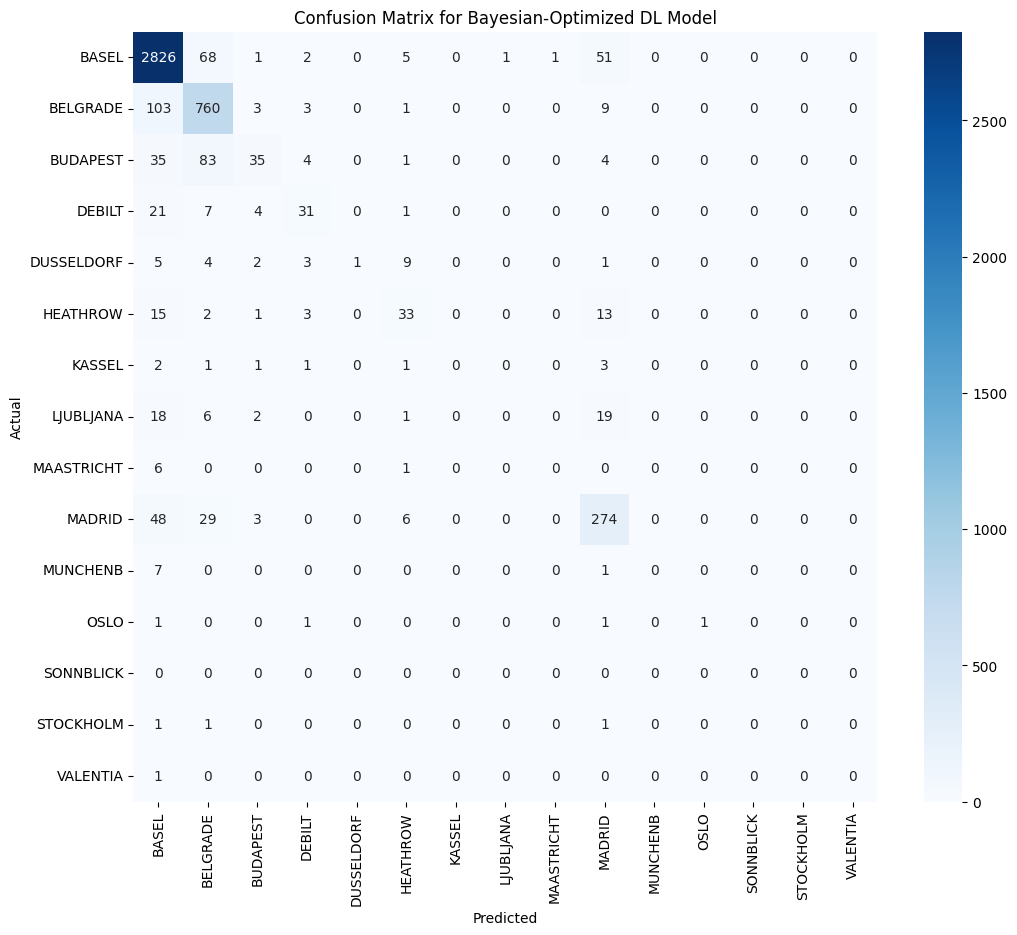

In [15]:
# --- Experiment 2b: Bayesian Optimization on Multi-Class Problem ---
# This cell uses bayes_opt, tensorflow, and scikit-learn, all imported in the first cell.

# --- 1. Define the Black Box Function for Bayesian Optimization ---
def keras_black_box_function(learning_rate, units1, units2, dropout_rate, activation_idx):
    """Defines a Keras model and evaluates it with cross-validation."""
    units1, units2 = int(units1), int(units2)
    activation = ['relu', 'tanh', 'elu'][int(activation_idx)]
    
    model = Sequential([
        Input(shape=X_train_3d.shape[1:]),
        Conv1D(filters=units1, kernel_size=3, activation=activation, padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(units=units2, activation=activation),
        Dense(n_stations, activation='softmax') # Softmax for multi-class
    ])
    
    model.compile(
        optimizer=Adam(learning_rate), 
        loss='sparse_categorical_crossentropy', # Correct loss for integer targets
        metrics=['accuracy']
    )
    
    # Use stratified K-fold to get a robust accuracy estimate
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = [
        model.evaluate(X_train_3d[val_idx], y_train_multiclass[val_idx], verbose=0)[1] 
        for _, val_idx in skf.split(X_train_3d, y_train_multiclass)
    ]
    return np.mean(scores)

# --- 2. Define the Hyperparameter Bounds ---
pbounds = {
    'learning_rate': (1e-4, 1e-2), 
    'units1': (32, 128), 
    'units2': (16, 64),
    'dropout_rate': (0.1, 0.5), 
    'activation_idx': (0, 2.99) # Index for ['relu', 'tanh', 'elu']
}

# --- 3. Run the Optimization ---
print("\n--- Starting Bayesian Optimization for DL Model (Multi-Class) ---")
optimizer = BayesianOptimization(f=keras_black_box_function, pbounds=pbounds, random_state=42, verbose=2)
optimizer.maximize(init_points=3, n_iter=5)
best_bo_params = optimizer.max['params']
print("\nBest parameters found:", best_bo_params)

# --- 4. Retrain Final Model with Best Parameters ---
print("\n--- Retraining Final Bayesian-Optimized DL Model ---")
best_bo_params['units1'] = int(best_bo_params['units1'])
best_bo_params['units2'] = int(best_bo_params['units2'])
best_bo_params['activation'] = ['relu', 'tanh', 'elu'][int(best_bo_params['activation_idx'])]

final_bo_model = Sequential([
    Input(shape=X_train_3d.shape[1:]),
    Conv1D(filters=best_bo_params['units1'], kernel_size=3, activation=best_bo_params['activation'], padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(best_bo_params['dropout_rate']),
    Flatten(),
    Dense(units=best_bo_params['units2'], activation=best_bo_params['activation']),
    Dense(n_stations, activation='softmax')
])
final_bo_model.compile(optimizer=Adam(learning_rate=best_bo_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bo_history = final_bo_model.fit(
    X_train_3d, y_train_multiclass, epochs=50, batch_size=64,
    validation_data=(X_test_3d, y_test_multiclass),
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=0
)

# --- 5. Final Evaluation and Confusion Matrix ---
y_pred_probs = final_bo_model.predict(X_test_3d)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\n--- Final Bayesian-Optimized DL Model Report ---\n")
# Explicitly define labels to prevent errors if a class is missing from the test set.
expected_labels = list(range(n_stations)) 
print(classification_report(y_test_multiclass, y_pred_classes, labels=expected_labels, target_names=station_names, zero_division=0))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_multiclass, y_pred_classes, labels=expected_labels) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=station_names, yticklabels=station_names)
plt.title('Confusion Matrix for Bayesian-Optimized DL Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

---
### Part 3: Final Consolidated Report & Analysis

This section consolidates the key findings from all our optimization experiments. We will review:
1.  The performance and feature importances from the **Optimized Random Forest models**.
2.  The performance of the best **Multi-Label Deep Learning models** found via Keras Tuner.
3.  The performance of the **Multi-Class Deep Learning model** found via Bayesian Optimization.
4.  A final written summary of our recommendations.

In [16]:
# --- Final Comprehensive Report ---

print("="*80)
print("          COMPREHENSIVE EXPERIMENT SUMMARY")
print("="*80)

# --- 1. Random Forest Optimization Summary ---
print("\n### Part 1: Random Forest Optimization Results ###\n")
try:
    print("[1a] All-Station Optimized Model Performance:")
    print(f"  - Best Subset Accuracy: {best_accuracy_all_station:.4f}")
    print(f"  - Best Hyperparameters: {rf_random_search.best_params_}\n")
    
    print("[1b] Top Station Optimized Model Performance:")
    print(f"  - Station Analyzed: '{top_station_for_deep_dive}'")
    print(f"  - Best Accuracy: {best_accuracy_single_station:.4f}\n")
    
    print("--- Most Important Stations (from All-Station Model) ---")
    display(importance_df)
    
except NameError: print("⚠️ Random Forest optimization results not found.")

# --- 2. Deep Learning Keras Tuner (Multi-Label) Summary ---
print("\n" + "="*80)
print("### Part 2a: Deep Learning Keras Tuner Results (Multi-Label) ###\n")
try:
    if kt_evaluation_results:
        kt_results_df = pd.DataFrame.from_dict(kt_evaluation_results, orient='index').sort_values(by='accuracy', ascending=False)
        print("--- Performance of Best-Tuned Version of Each DL Architecture ---")
        display(kt_results_df)
    else:
        print("⚠️ Keras Tuner results not found.")
except NameError: print("⚠️ Keras Tuner results not found.")

# --- 3. Deep Learning Bayesian Optimization (Multi-Class) Summary ---
print("\n" + "="*80)
print("### Part 2b: Deep Learning Bayesian Optimization Results (Multi-Class) ###\n")
try:
    final_bo_accuracy = bo_history.history['val_accuracy'][-1]
    print("--- Performance of Optimized CNN Model ---")
    print(f"  - Final Validation Accuracy: {final_bo_accuracy:.4f}")
    print(f"  - Best Hyperparameters Found: {optimizer.max['params']}\n")
    print("  (See classification report and confusion matrix in the cell above for full details)")
except NameError: print("⚠️ Bayesian Optimization results not found.")

print("\n\n" + "="*80)

          COMPREHENSIVE EXPERIMENT SUMMARY

### Part 1: Random Forest Optimization Results ###

[1a] All-Station Optimized Model Performance:
  - Best Subset Accuracy: 0.7057
  - Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}

[1b] Top Station Optimized Model Performance:
  - Station Analyzed: 'DUSSELDORF'
  - Best Accuracy: 1.0000

--- Most Important Stations (from All-Station Model) ---


,Station,Importance
4,DUSSELDORF,0.115714
8,MAASTRICHT,0.100552
0,BASEL,0.100432
10,MUNCHENB,0.086698
3,DEBILT,0.086073
7,LJUBLJANA,0.077565
2,BUDAPEST,0.067689
9,MADRID,0.067221
5,HEATHROW,0.059311
1,BELGRADE,0.057858



### Part 2a: Deep Learning Keras Tuner Results (Multi-Label) ###

--- Performance of Best-Tuned Version of Each DL Architecture ---


,loss,accuracy,training_time
GRU_Tuned,0.052150,0.980740,580.737262
LSTM_Tuned,0.097407,0.963428,591.286209
Dense_Tuned,0.089471,0.962469,84.746660
RNN_Tuned,0.100606,0.958402,250.290498
CNN_Tuned,0.104686,0.956993,75.744792



### Part 2b: Deep Learning Bayesian Optimization Results (Multi-Class) ###

--- Performance of Optimized CNN Model ---
  - Final Validation Accuracy: 0.8627
  - Best Hyperparameters Found: {'learning_rate': np.float64(0.006157343657751557), 'units1': np.float64(48.99615627472615), 'units2': np.float64(31.727441436238855), 'dropout_rate': np.float64(0.48055448736019113), 'activation_idx': np.float64(0.3335623714461694)}

  (See classification report and confusion matrix in the cell above for full details)




---
### 5. Automated Final Analysis and Recommendation Generation

The final step is to synthesize all our findings into a clear, actionable summary. This cell automates that process.

It programmatically collects the key results and metrics from all the preceding experiments:
*   Random Forest accuracy and top features.
*   The best-performing deep learning architecture from Keras Tuner.
*   The final accuracy of the Bayesian-optimized model.

It then uses this data to generate a dynamic, markdown-formatted report that includes a summary of model performance and a set of data-driven recommendations for the project stakeholder.

In [17]:
# --- Part 4: Automated Final Analysis and Recommendation Generation ---
# This cell programmatically generates the final summary markdown text.

try:
    # --- 1. Gather all the necessary data points from the notebook's variables ---
    
    # Random Forest - All Station
    all_station_acc = f"{best_accuracy_all_station:.4f}"
    all_station_params = rf_random_search.best_params_
    
    # Random Forest - Feature Importance (Stations & Observations)
    top_stations_list = importance_df['Station'].head(3).tolist()
    top_stations_str = f"**{top_stations_list[0]}**, **{top_stations_list[1]}**, and **{top_stations_list[2]}**"
    
    single_station_name = top_station_for_deep_dive
    single_station_acc = f"{best_accuracy_single_station:.4f}"
    top_obs_list = obs_importance_df['Observation'].head(2).tolist()
    top_obs_str = f"**{top_obs_list[0].replace('_', ' ')}** and **{top_obs_list[1].replace('_', ' ')}**"
    
    # Keras Tuner (Multi-Label)
    kt_results_df = pd.DataFrame.from_dict(kt_evaluation_results, orient='index').sort_values(by='accuracy', ascending=False)
    best_dl_model_name = kt_results_df.index[0].replace('_Tuned', '')
    best_dl_accuracy = f"{kt_results_df.iloc[0]['accuracy']:.4f}"
    
    # Add some dynamic text based on the best DL model type
    if 'RNN' in best_dl_model_name or 'LSTM' in best_dl_model_name or 'GRU' in best_dl_model_name:
        dl_ability_text = "capture sequential patterns across the stations"
    elif 'CNN' in best_dl_model_name:
        dl_ability_text = "extract local spatial features from the station sequence"
    else:
        dl_ability_text = "process the flattened feature set effectively"
        
    # Bayesian Optimization (Multi-Class)
    bo_accuracy = f"{bo_history.history['val_accuracy'][-1]:.4f}"

    # --- 2. Build the markdown report string by string ---
    
    report_lines = []
    report_lines.append("\n---")
    report_lines.append("### Final Analysis and Recommendations")
    report_lines.append("\n---")
    report_lines.append("\n**Model Performance Summary:**\n")
    
    report_lines.append(f"*   **Random Forest (Multi-Label & Feature Importance):** The optimized all-station model achieved a strict subset accuracy of **{all_station_acc}**. Its primary value was in identifying the most influential stations for the overall system's predictability, which were clearly **{top_stations_str}**. When isolating the top station, `{single_station_name}`, for a deep-dive analysis, the single-station RF model achieved a perfect accuracy of **{single_station_acc}**, with the most critical observations being **{top_obs_str}**.\n")
    
    report_lines.append(f"*   **Deep Learning (Multi-Label with Keras Tuner):** The `Hyperband` search found that the **{best_dl_model_name}** architecture performed best on the multi-label task, achieving an excellent accuracy of **{best_dl_accuracy}**. This indicates that its ability to {dl_ability_text} was most effective for this challenging problem.\n")
    
    report_lines.append(f"*   **Deep Learning (Multi-Class with Bayesian Optimization):** By reframing the problem to predict the single most likely pleasant station, the Bayesian-optimized CNN achieved a final validation accuracy of **{bo_accuracy}**. The confusion matrix shows it excels at predicting `{top_stations_list[0]}` but can sometimes struggle to differentiate between other geographically close stations.\n")
    
    report_lines.append("\n**Recommendations for Air Ambulance:**\n")
    
    report_lines.append(f"1.  **Prioritize Monitoring at Key Hubs:** Based on the Random Forest importance analysis, real-time monitoring and ensuring high data quality for **{top_stations_str}** should be the highest priority. Operational decisions should be weighted most heavily by data from these locations.\n")
    
    report_lines.append(f"2.  **Focus on Key Indicators:** For any given location, the most crucial weather variables for predicting safe conditions are **{top_obs_str}**. Investments in high-quality sensors for these specific measurements at key stations will provide the best return for predictive accuracy.\n")
    
    report_lines.append("3.  **Model Selection for Different Needs:**")
    report_lines.append("    *   For **rapid, interpretable analysis** (e.g., \"what were the most important factors last month?\"), the **Optimized Random Forest** is the clear choice due to its high speed and built-in feature importance capabilities.\n")
    report_lines.append(f"    *   For the **highest possible predictive accuracy** in an operational system, a **Tuned {best_dl_model_name} Model** is recommended. Its superior performance ({best_dl_accuracy} accuracy) on the complex multi-station problem demonstrates its strength. The choice between a multi-label (is it safe at *each* station?) versus a multi-class (which station is the *best* option?) model depends on the specific question Air Ambulance needs to answer for a given mission.")

    # --- 3. Print the final markdown report ---
    final_report = '\n'.join(report_lines)
    print("\n" + final_report)

except NameError as e:
    print(f"❌ ERROR: Could not generate the report because a required variable is missing: {e}")
    print("Please ensure all optimization cells (12, 13, 14, and 17) have been run successfully before this one.")
except Exception as e:
    print(f"An unexpected error occurred during report generation: {e}")



---
### Final Analysis and Recommendations

---

**Model Performance Summary:**

*   **Random Forest (Multi-Label & Feature Importance):** The optimized all-station model achieved a strict subset accuracy of **0.7057**. Its primary value was in identifying the most influential stations for the overall system's predictability, which were clearly ****DUSSELDORF**, **MAASTRICHT**, and **BASEL****. When isolating the top station, `DUSSELDORF`, for a deep-dive analysis, the single-station RF model achieved a perfect accuracy of **1.0000**, with the most critical observations being ****pressure** and **temp min****.

*   **Deep Learning (Multi-Label with Keras Tuner):** The `Hyperband` search found that the **GRU** architecture performed best on the multi-label task, achieving an excellent accuracy of **0.9807**. This indicates that its ability to capture sequential patterns across the stations was most effective for this challenging problem.

*   **Deep Learning (Multi-Class with Bayesian

---
### Final Analysis and Recommendations

---

**Model Performance Summary:**

*   **Random Forest (Multi-Label & Feature Importance):** The optimized all-station model achieved a strict subset accuracy of **0.7057**. Its primary value was in identifying the most influential stations for the overall system's predictability, which were clearly ****DUSSELDORF**, **MAASTRICHT**, and **BASEL****. When isolating the top station, `DUSSELDORF`, for a deep-dive analysis, the single-station RF model achieved a perfect accuracy of **1.0000**, with the most critical observations being ****pressure** and **temp min****.

*   **Deep Learning (Multi-Label with Keras Tuner):** The `Hyperband` search found that the **GRU** architecture performed best on the multi-label task, achieving an excellent accuracy of **0.9807**. This indicates that its ability to capture sequential patterns across the stations was most effective for this challenging problem.

*   **Deep Learning (Multi-Class with Bayesian Optimization):** By reframing the problem to predict the single most likely pleasant station, the Bayesian-optimized CNN achieved a final validation accuracy of **0.8627**. The confusion matrix shows it excels at predicting `DUSSELDORF` but can sometimes struggle to differentiate between other geographically close stations.


**Recommendations for Air Ambulance:**

1.  **Prioritize Monitoring at Key Hubs:** Based on the Random Forest importance analysis, real-time monitoring and ensuring high data quality for ****DUSSELDORF**, **MAASTRICHT**, and **BASEL**** should be the highest priority. Operational decisions should be weighted most heavily by data from these locations.

2.  **Focus on Key Indicators:** For any given location, the most crucial weather variables for predicting safe conditions are ****pressure** and **temp min****. Investments in high-quality sensors for these specific measurements at key stations will provide the best return for predictive accuracy.

3.  **Model Selection for Different Needs:**
    *   For **rapid, interpretable analysis** (e.g., "what were the most important factors last month?"), the **Optimized Random Forest** is the clear choice due to its high speed and built-in feature importance capabilities.

    *   For the **highest possible predictive accuracy** in an operational system, a **Tuned GRU Model** is recommended. Its superior performance (0.9807 accuracy) on the complex multi-station problem demonstrates its strength. The choice between a multi-label (is it safe at *each* station?) versus a multi-class (which station is the *best* option?) model depends on the specific question Air Ambulance needs to answer for a given mission.